<a href="https://colab.research.google.com/github/madhumitha98/AI_Projects/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive (3).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

In [ ]:
path = "/tmp/images"

dataset = tf.keras.preprocessing.image_dataset_from_directory(path, label_mode=None, image_size=(64,64),batch_size=128)

Found 63565 files belonging to 1 classes.


In [ ]:
dataset = dataset.map(lambda x: (x / 127.5) - 1)

AxesImage(size=(64, 64))
(64, 64, 3)
128


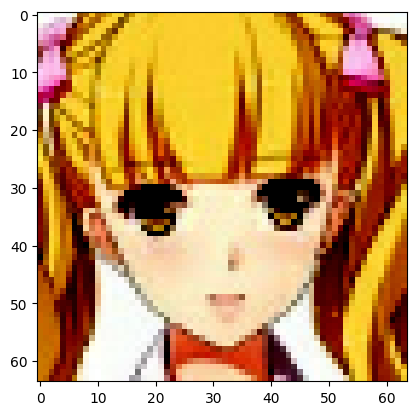

In [ ]:
for img in dataset:
  print(plt.imshow(img[0]))
  print(img[0].shape)
  print(len(img))
  break

## Model

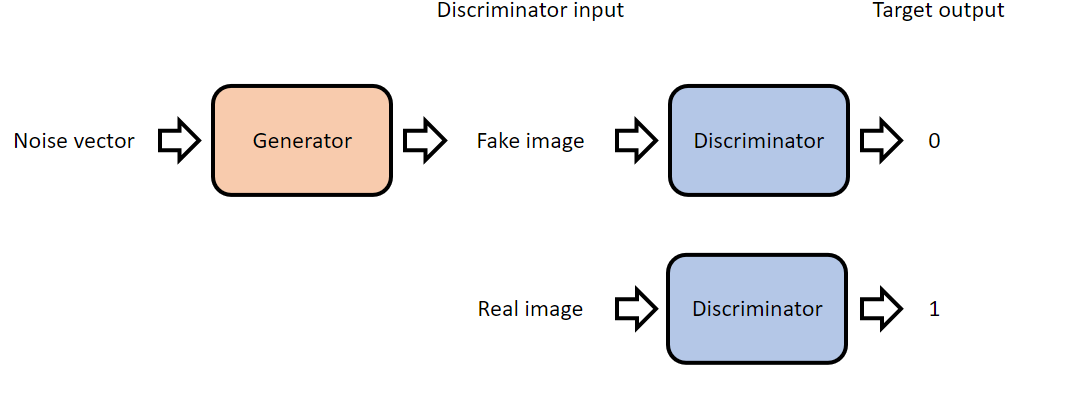

In [ ]:
code_size = 100
batch_size = 128
generator = keras.Sequential()
generator.add(layers.Input(shape=(100,)))
generator.add(layers.Dense(4*4*256))
generator.add(layers.BatchNormalization())
generator.add(layers.ReLU())
generator.add(layers.Reshape((4,4,256)))
generator.add(layers.Conv2DTranspose(128,kernel_size=4,padding='same',strides=2))
generator.add(layers.BatchNormalization())
generator.add(layers.ReLU())
generator.add(layers.Conv2DTranspose(64,kernel_size=4,padding='same',strides=2))
generator.add(layers.BatchNormalization())
generator.add(layers.ReLU())
generator.add(layers.Conv2DTranspose(32,kernel_size=4,padding='same',strides=2))
generator.add(layers.BatchNormalization())
generator.add(layers.ReLU())
generator.add(layers.Conv2DTranspose(3,kernel_size=4,padding='same',strides=2))
generator.add(layers.Activation('tanh'))

In [ ]:
import numpy as np
np.random.normal(0,1,10)


array([ 1.59674488,  1.03771714,  0.69160096,  0.56207694,  0.82162923,
       -0.00169455,  0.12448487,  1.58488446,  0.25395313,  0.37549336])

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)       

In [ ]:
image_shape = (64,64,3)
discriminator = keras.Sequential()
discriminator.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

In [ ]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real,fake):
  real_loss = loss(tf.ones_like(real),real)
  fake_loss = loss(tf.zeros_like(fake),fake)
  return real_loss + fake_loss

In [ ]:
def generator_loss(fake):
  gen_loss = loss(tf.ones_like(fake),fake)
  return gen_loss

In [ ]:
generator_optimizer = keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = keras.optimizers.Adam(0.0002,0.5)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  gen_loss=0
  dis_loss=0
  gen_plot = []
  dis_plot = []
  for epoch in range(epochs):
    print(f'{epoch+1} of {epochs}',end = ' ')
    print(f'generator loss is {gen_loss} and discriminator loss is {dis_loss}')
    for image_batch in dataset:
      gen_loss,dis_loss = train_step(image_batch)
    gen_plot.append(gen_loss)
    dis_plot.append(dis_loss)
  x = [X for X in range(epochs)]
  plt.plot(x,gen_plot)
  plt.plot(x,dis_plot)
  plt.title('epoch vs loss')
  plt.legend(['gen_loss','dis_loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

1 of 20 generator loss is 0 and discriminator loss is 0
2 of 20 generator loss is 3.2214014530181885 and discriminator loss is 0.45186764001846313
3 of 20 generator loss is 0.8902219533920288 and discriminator loss is 1.5702989101409912
4 of 20 generator loss is 1.8471876382827759 and discriminator loss is 0.5990465879440308
5 of 20 generator loss is 3.0792810916900635 and discriminator loss is 0.5214098691940308
6 of 20 generator loss is 3.924001932144165 and discriminator loss is 0.25995951890945435
7 of 20 generator loss is 7.27365255355835 and discriminator loss is 0.47910815477371216
8 of 20 generator loss is 4.950681686401367 and discriminator loss is 0.17554882168769836
9 of 20 generator loss is 2.280271291732788 and discriminator loss is 0.5976626873016357
10 of 20 generator loss is 2.7180545330047607 and discriminator loss is 0.4737240672111511
11 of 20 generator loss is 2.291093587875366 and discriminator loss is 0.4605400264263153
12 of 20 generator loss is 2.827988862991333

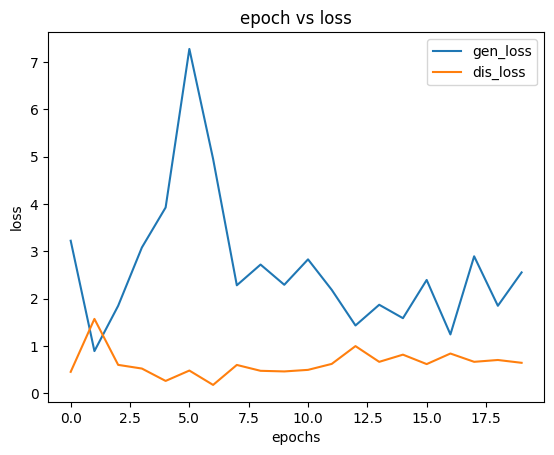

In [ ]:
train(dataset,20)

In [ ]:
noice = np.random.randn(32,100)
pred = generator.predict(noice)

1/1 [==============================] - 0s 269ms/step


In [ ]:
noice = np.random.randn(32,100)
noice

array([[-0.02750156,  0.6216297 ,  0.28401603, ...,  0.66084992,
         0.39920556,  0.46481697],
       [ 0.93479345, -0.90441023,  0.2375062 , ...,  0.92281272,
         1.51506828, -0.09280603],
       [-1.01646281, -0.87581175,  0.1379358 , ..., -1.12695823,
        -1.13920431,  0.00351206],
       ...,
       [ 0.20517058, -1.05969607,  1.42063872, ..., -0.82204952,
         1.44737099, -2.65711876],
       [ 0.49902357,  0.15980489, -0.99370938, ..., -1.24463363,
        -1.13766218,  0.33113251],
       [-0.41943869, -0.38292165, -0.57612961, ...,  0.59342072,
        -0.36335418, -0.01381091]])

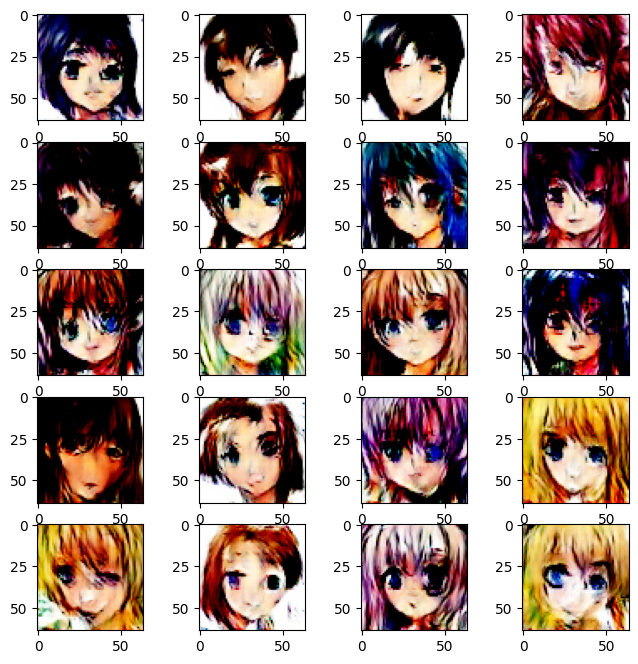

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()
